In [ ]:
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Path to the Parquet file generated in the clustering notebook
DATA_PATH = Path("bike_data_clean.parquet")

# Clusters to model (you can change this list)
CLUSTERS_TO_MODEL = [0, 1]

# Show all figures inline
%matplotlib inline

In [13]:
# ------------------------------------------------------------
# Utilities to build hourly demand per cluster
# ------------------------------------------------------------

def build_hourly_demand_for_cluster(df: pd.DataFrame, cluster_id: int) -> pd.DataFrame:
    """Builds an hourly demand table for a specific cluster.

    Output: DataFrame with columns:
        - date (datetime)
        - hour (0..23)
        - pickups  (trips starting in this cluster)
        - dropoffs (trips ending in this cluster)
        - cluster_id
    """
    df_pick = df[df["gmm20_cluster"] == cluster_id]
    df_drop = df[df["end_gmm20_cluster"] == cluster_id]

    if df_pick.empty and df_drop.empty:
        raise ValueError(f"No trip data for cluster {cluster_id}")

    # --- Add pickups: origin in this cluster ---
    pick_group = (
        df_pick
        .groupby(["start_date", "start_hour"])
        .size()
        .rename("pickups")
        .reset_index()
    )

    # --- Add dropoffs: destination in this cluster ---
    drop_group = (
        df_drop
        .groupby(["stop_date", "stop_hour"])
        .size()
        .rename("dropoffs")
        .reset_index()
    )

    # Rename columns to a common format (date, hour)
    pick_group = pick_group.rename(
        columns={"start_date": "date", "start_hour": "hour"}
    )
    drop_group = drop_group.rename(
        columns={"stop_date": "date", "stop_hour": "hour"}
    )

    # Normalize dates to day
    pick_group["date"] = pd.to_datetime(pick_group["date"]).dt.normalize()
    drop_group["date"] = pd.to_datetime(drop_group["date"]).dt.normalize()

    # Full range of dates and hours to cover (fill with 0 when no trips)
    min_date = min(pick_group["date"].min(), drop_group["date"].min())
    max_date = max(pick_group["date"].max(), drop_group["date"].max())
    all_dates = pd.date_range(min_date, max_date, freq="D")
    hours = np.arange(24)

    # Create an index of all combinations (date, hour)
    idx = pd.MultiIndex.from_product([all_dates, hours], names=["date", "hour"])
    hourly = pd.DataFrame(index=idx).reset_index()

    # Join with pickups and dropoffs tables
    hourly = hourly.merge(pick_group, on=["date", "hour"], how="left")
    hourly = hourly.merge(drop_group, on=["date", "hour"], how="left")

    # Fill NaN with 0 (no trips that hour)
    hourly["pickups"] = hourly["pickups"].fillna(0).astype("float32")
    hourly["dropoffs"] = hourly["dropoffs"].fillna(0).astype("float32")

    hourly["cluster_id"] = cluster_id

    return hourly

In [ ]:
# ------------------------------------------------------------
# Supervised Dataset (Day D -> Day D+1)
# ------------------------------------------------------------

def build_supervised_from_hourly(
    hourly_df: pd.DataFrame,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DatetimeIndex]:
    """Builds the supervised dataset at the day level.

    For each day d:
        X_d  = [
            24h pickups(d), 
            24h dropoffs(d), 
            24h pickups(d-7),
            24h dropoffs(d-7),
            weekday(d+1), 
            is_weekend(d+1),
            month(d+1)
        ]
        y_d  = 24h pickups(d+1)
        y2_d = 24h dropoffs(d+1)
    """
    # Pivot to day x hour matrices
    daily_p = hourly_df.pivot(index="date", columns="hour", values="pickups")
    daily_d = hourly_df.pivot(index="date", columns="hour", values="dropoffs")

    # Ensure all columns 0..23 exist
    for h in range(24):
        if h not in daily_p.columns:
            daily_p[h] = 0.0
        if h not in daily_d.columns:
            daily_d[h] = 0.0

    daily_p = daily_p[sorted(daily_p.columns)]
    daily_d = daily_d[sorted(daily_d.columns)]

    # Sort by date
    dates = daily_p.index.sort_values()
    daily_p = daily_p.loc[dates]
    daily_d = daily_d.loc[dates]

    X_list: List[np.ndarray] = []
    Yp_list: List[np.ndarray] = []
    Yd_list: List[np.ndarray] = []
    pred_dates: List[pd.Timestamp] = []

    # Start from 7 to allow for weekly lag
    for i in range(7, len(dates) - 1):
        d = dates[i]
        d_next = dates[i + 1]
        d_last_week = dates[i - 6] # Same day of week as d_next, but 1 week prior

        is_weekend = 1.0 if d_next.weekday() >= 5 else 0.0

        # Features: 
        # 1. Yesterday's demand (d)
        # 2. Last week's demand (d_last_week)
        # 3. Calendar features of target day (d_next)
        X_vec = np.concatenate(
            [
                daily_p.loc[d].values.astype("float32"),
                daily_d.loc[d].values.astype("float32"),
                daily_p.loc[d_last_week].values.astype("float32"),
                daily_d.loc[d_last_week].values.astype("float32"),
                np.array([d_next.weekday(), is_weekend, d_next.month], dtype="float32"),
            ]
        )

        # Targets: 24h of the next day
        y_pick = daily_p.loc[d_next].values.astype("float32")
        y_drop = daily_d.loc[d_next].values.astype("float32")

        X_list.append(X_vec)
        Yp_list.append(y_pick)
        Yd_list.append(y_drop)
        pred_dates.append(d_next)

    X = np.stack(X_list)
    Yp = np.stack(Yp_list)
    Yd = np.stack(Yd_list)
    pred_dates = pd.to_datetime(pred_dates)

    return X, Yp, Yd, pred_dates


def split_train_test(
    X: np.ndarray,
    Yp: np.ndarray,
    Yd: np.ndarray,
    pred_dates: pd.DatetimeIndex,
):
    """Temporal train/test split:

    - Train: predicted dates < 2018-11-01 (Jan–Oct)
    - Test : predicted dates >= 2018-11-01 (Nov–Dec)
    """
    cutoff = pd.to_datetime("2018-11-01")
    train_mask = pred_dates < cutoff
    test_mask = pred_dates >= cutoff

    X_train = X[train_mask]
    X_test = X[test_mask]
    Yp_train = Yp[train_mask]
    Yp_test = Yp[test_mask]
    Yd_train = Yd[train_mask]
    Yd_test = Yd[test_mask]
    dates_train = pred_dates[train_mask]
    dates_test = pred_dates[test_mask]

    return X_train, X_test, Yp_train, Yp_test, Yd_train, Yd_test, dates_train, dates_test

In [15]:
# ------------------------------------------------------------
# MLP + Task 3 (required bikes)
# ------------------------------------------------------------

def train_mlp(X_train: np.ndarray, Y_train: np.ndarray):
    """Trains an MLPRegressor for multi-output regression.

    Returns the model and the scaler used on the features.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1,
    )

    mlp.fit(X_train_scaled, Y_train)
    return mlp, scaler


def compute_required_bikes_series(Yp: np.ndarray, Yd: np.ndarray) -> np.ndarray:
    """Task 3: calculates the # of bikes required at the start of the day.

    net_t = dropoffs_t - pickups_t
    cum_net_k = sum_{t=0..k} net_t
    required_bikes = max(0, -min_k cum_net_k)
    """
    required = []
    for pickups, dropoffs in zip(Yp, Yd):
        net = dropoffs - pickups
        cum_net = np.cumsum(net)
        min_cum = float(cum_net.min())
        req = max(0.0, -min_cum)
        required.append(req)
    return np.array(required, dtype="float32")


def evaluate_cluster_with_mlp(
    df: pd.DataFrame,
    cluster_id: int,
):
    """Complete pipeline for a cluster:
      - Hourly demand
      - Supervised dataset day -> day+1
      - Temporal split
      - Training of two MLPs (pickups and dropoffs)
      - Evaluation
      - Calculation of required bikes (Task 3)
      - Main plots
    """
    print("\n" + "=" * 80)
    print(f"CLUSTER {cluster_id} - Building hourly demand ...")
    hourly = build_hourly_demand_for_cluster(df, cluster_id)
    print(f"[INFO] hourly shape: {hourly.shape}")

    print("[INFO] Building supervised dataset day -> day+1 ...")
    X, Yp, Yd, pred_dates = build_supervised_from_hourly(hourly)
    print(f"[INFO] Number of samples (days-1): {X.shape[0]}")

    print("[INFO] Temporal split (train = Jan–Oct, test = Nov–Dec) ...")
    (
        X_train,
        X_test,
        Yp_train,
        Yp_test,
        Yd_train,
        Yd_test,
        dates_train,
        dates_test,
    ) = split_train_test(X, Yp, Yd, pred_dates)

    print(f"  Train samples: {X_train.shape[0]}")
    print(f"  Test samples : {X_test.shape[0]}")

    if X_test.shape[0] == 0:
        print("[WARN] No days in the test set for this cluster (Nov–Dec). Skipping.")
        return

    # --------------------- MLP Training ---------------------
    print("[INFO] Training MLP for pickups ...")
    mlp_pickups, scaler_p = train_mlp(X_train, Yp_train)
    X_test_scaled_p = scaler_p.transform(X_test)
    Yp_pred_test = mlp_pickups.predict(X_test_scaled_p)

    print("[INFO] Training MLP for dropoffs ...")
    mlp_dropoffs, scaler_d = train_mlp(X_train, Yd_train)
    X_test_scaled_d = scaler_d.transform(X_test)
    Yd_pred_test = mlp_dropoffs.predict(X_test_scaled_d)

    # --------------------- Metrics ---------------------
    rmse_p = np.sqrt(mean_squared_error(Yp_test.ravel(), Yp_pred_test.ravel()))
    mae_p = mean_absolute_error(Yp_test.ravel(), Yp_pred_test.ravel())
    rmse_d = np.sqrt(mean_squared_error(Yd_test.ravel(), Yd_pred_test.ravel()))
    mae_d = mean_absolute_error(Yd_test.ravel(), Yd_pred_test.ravel())

    print(f"\n[RESULTS] Cluster {cluster_id}")
    print(f"  Pickups  - RMSE={rmse_p:.3f}, MAE={mae_p:.3f}")
    print(f"  Dropoffs - RMSE={rmse_d:.3f}, MAE={mae_d:.3f}")

    # --------------------- Task 3: Required Bikes ---------------------
    print("[INFO] Calculating required bikes (Task 3) with predictions and actual data ...")
    required_pred = compute_required_bikes_series(Yp_pred_test, Yd_pred_test)
    required_true = compute_required_bikes_series(Yp_test, Yd_test)

    df_req = pd.DataFrame(
        {
            "date": dates_test,
            "required_bikes_true": required_true,
            "required_bikes_pred": required_pred,
        }
    )

    print("\n[Task 3] Example of required bikes (first 10 test days):")
    print(df_req.head(10))

    # --------------------- Plots ---------------------
    hours = np.arange(24)

    # 1) Example of test day (first day)
    idx0 = 0
    date0 = dates_test[idx0].date()

    plt.figure(figsize=(9, 5))
    plt.plot(hours, Yp_test[idx0], marker="o", label="Actual pickups")
    plt.plot(hours, Yp_pred_test[idx0], marker="x", label="Predicted pickups")
    plt.xlabel("Hour")
    plt.ylabel("Demand")
    plt.title(f"Cluster {cluster_id} - Pickups - {date0}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.figure(figsize=(9, 5))
    plt.plot(hours, Yd_test[idx0], marker="o", label="Actual dropoffs")
    plt.plot(hours, Yd_pred_test[idx0], marker="x", label="Predicted dropoffs")
    plt.xlabel("Hour")
    plt.ylabel("Demand")
    plt.title(f"Cluster {cluster_id} - Dropoffs - {date0}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # 2) Required bikes on several test days (bars)
    plt.figure(figsize=(10, 5))
    x = np.arange(min(10, len(df_req)))  # max 10 days to visualize

    plt.bar(
        x - 0.15,
        df_req["required_bikes_true"].values[: len(x)],
        width=0.3,
        label="True",
    )
    plt.bar(
        x + 0.15,
        df_req["required_bikes_pred"].values[: len(x)],
        width=0.3,
        label="Predicted",
    )

    # Date labels
    date_labels = df_req["date"].dt.strftime("%Y-%m-%d").values[: len(x)]
    plt.xticks(x, date_labels, rotation=45)

    plt.ylabel("Required bikes at start of day")
    plt.title(f"Cluster {cluster_id} - Required bikes (Task 3) - First test days")
    plt.legend()
    plt.tight_layout()

    plt.show()

MLP DEMAND PREDICTION (Task 2 & Task 3)
[INFO] Reading data from C:\Users\andre\Desktop\DTU\Semester 3\Introduction to Buisness Analytics\Project\Intro_to_BA\bike_data_clean.parquet ...
[INFO] DataFrame shape: (17531179, 22)
[INFO] Available columns (first 20):
Index(['tripduration', 'start_station_id', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_latitude',
       'end_station_longitude', 'bikeid', 'birth_year', 'gender', 'usertype',
       'start_date', 'start_hour', 'start_minute', 'stop_date', 'stop_hour',
       'stop_minute', 'start_weekday', 'start_month', 'start_year'],
      dtype='object')

CLUSTER 0 - Building hourly demand ...
[INFO] DataFrame shape: (17531179, 22)
[INFO] Available columns (first 20):
Index(['tripduration', 'start_station_id', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_latitude',
       'end_station_longitude', 'bikeid', 'birth_year', 'gender', 'usertype',
       '

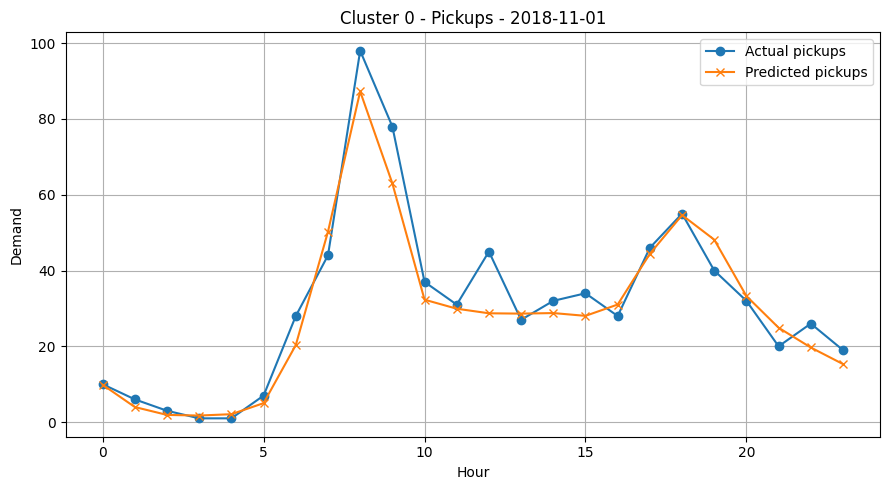

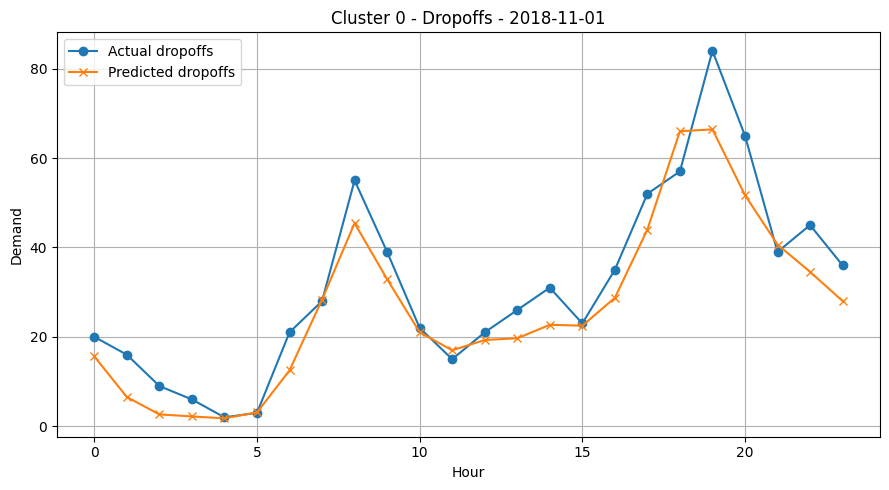

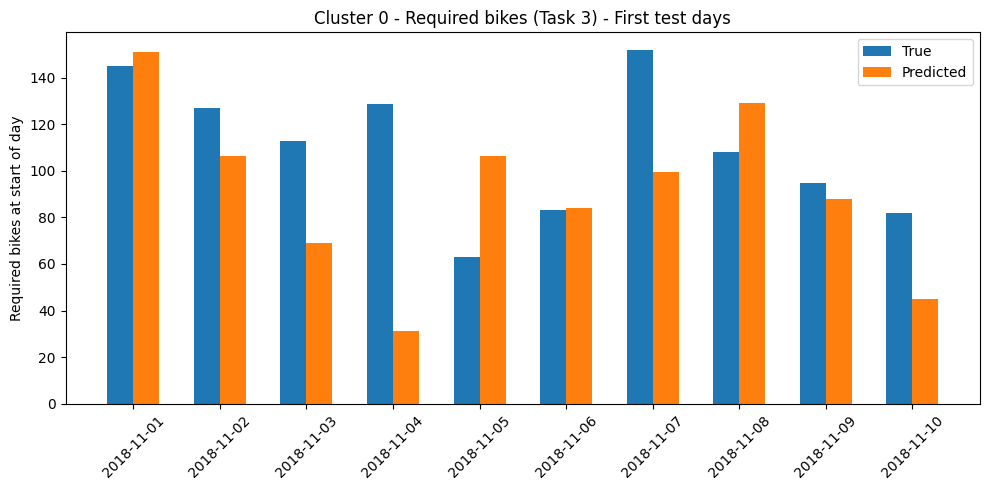


CLUSTER 1 - Building hourly demand ...
[INFO] hourly shape: (8760, 5)
[INFO] Building supervised dataset day -> day+1 ...
[INFO] Number of samples (days-1): 357
[INFO] Temporal split (train = Jan–Oct, test = Nov–Dec) ...
  Train samples: 296
  Test samples : 61
[INFO] Training MLP for pickups ...
[INFO] hourly shape: (8760, 5)
[INFO] Building supervised dataset day -> day+1 ...
[INFO] Number of samples (days-1): 357
[INFO] Temporal split (train = Jan–Oct, test = Nov–Dec) ...
  Train samples: 296
  Test samples : 61
[INFO] Training MLP for pickups ...
[INFO] Training MLP for dropoffs ...
[INFO] Training MLP for dropoffs ...

[RESULTS] Cluster 1
  Pickups  - RMSE=37.199, MAE=24.041
  Dropoffs - RMSE=38.888, MAE=24.697
[INFO] Calculating required bikes (Task 3) with predictions and actual data ...

[Task 3] Example of required bikes (first 10 test days):
        date  required_bikes_true  required_bikes_pred
0 2018-11-01                320.0           260.667236
1 2018-11-02             

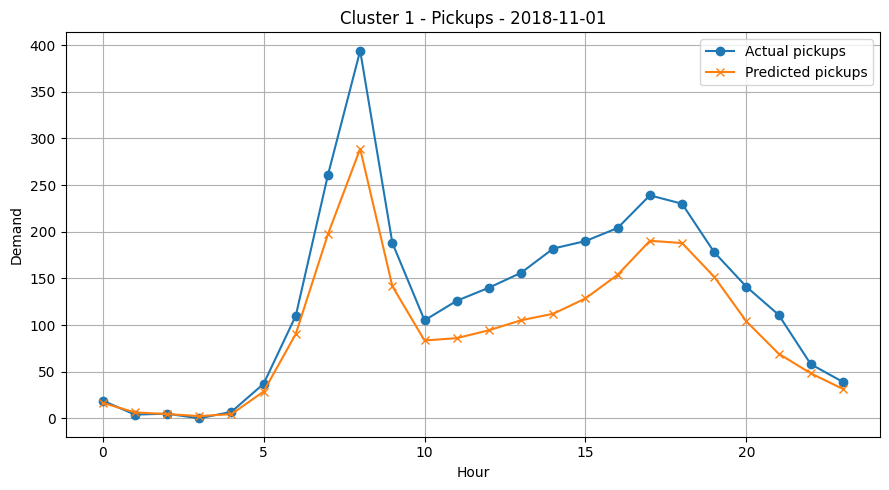

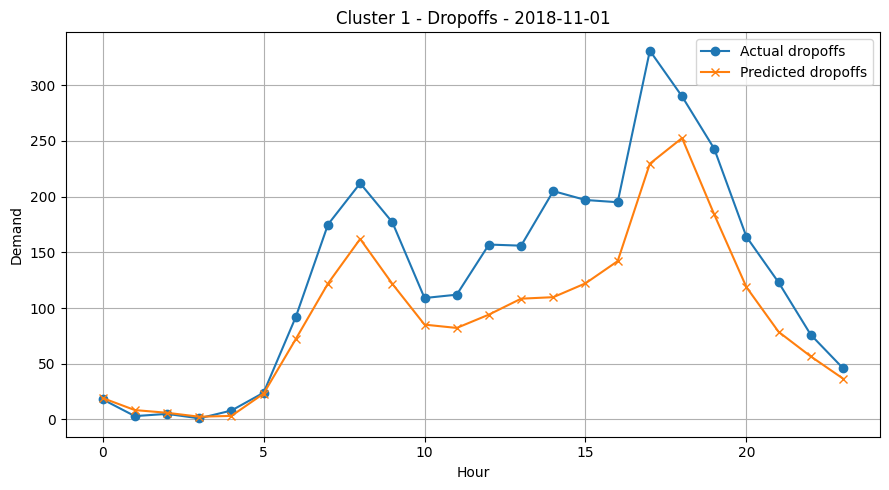

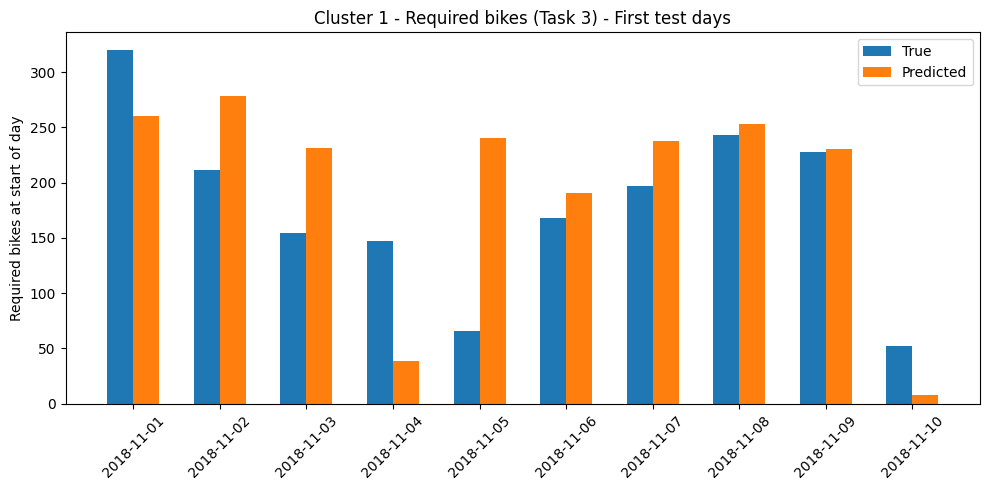

In [16]:
# ------------------------------------------------------------
# MLP Pipeline Execution
# ------------------------------------------------------------

print("=" * 80)
print("MLP DEMAND PREDICTION (Task 2 & Task 3)")
print("=" * 80)
print(f"[INFO] Reading data from {DATA_PATH.resolve()} ...")

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"{DATA_PATH} not found. "
        "Run the clustering notebook first to generate bike_data_clean.parquet."
    )

df = pd.read_parquet(DATA_PATH)

print(f"[INFO] DataFrame shape: {df.shape}")
print("[INFO] Available columns (first 20):")
print(df.columns[:20])

for cluster_id in CLUSTERS_TO_MODEL:
    try:
        evaluate_cluster_with_mlp(df, cluster_id)
    except ValueError as e:
        print(f"[WARN] Cluster {cluster_id}: {e}")